<a href="https://colab.research.google.com/github/ECastro08/challenge_telecomX_2/blob/main/Challenge_2_telecomX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Librerias**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## **Leyendo archivo**

In [2]:
data_source = '/content/df_telecom.csv'
data = pd.read_csv(data_source)

In [3]:
data.head(3)

,customer_id,churn,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,cuentas_diarias
0,0002-ORFBO,0,Female,0,1,1,9,1,0,DSL,...,0,1,1,0,One year,1,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,0,Male,0,0,0,9,1,1,DSL,...,0,0,0,1,Month-to-month,0,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,1,Male,0,0,0,4,1,0,Fiber optic,...,1,0,0,0,Month-to-month,1,Electronic check,73.9,280.85,2.463333


## **Eliminacion de columnas irrelevantes**

In [4]:
# Analisis de correlacion para mirar una posible multicolinealidad entre variables que podrian ser dependientes entre si
data[['tenure', 'monthly_charges', 'total_charges', 'cuentas_diarias']].corr()

,tenure,monthly_charges,total_charges,cuentas_diarias
tenure,1.000000,0.247900,0.826178,0.247900
monthly_charges,0.247900,1.000000,0.651174,1.000000
total_charges,0.826178,0.651174,1.000000,0.651174
cuentas_diarias,0.247900,1.000000,0.651174,1.000000


Durante el análisis de correlación se identificó una alta correlación (≈0.82) entre **total_charges** y **tenure**. Esta relación fuerte indica presencia de multicolinealidad, ya que total_charges es una variable acumulativa que depende directamente del tiempo de permanencia del cliente y del cargo mensual.

Para evitar redundancia de información y posibles problemas en modelos lineales (como inestabilidad en los coeficientes), se decidió eliminar la variable **total_charges**, conservando tenure y monthly_charges por su mayor interpretabilidad y relevancia directa en el análisis de churn.
Ademas se elimino la columna cuentas diarias, al ser esta una columna dependiente de otras tampoco va aportar informacion al modelo.

In [5]:
# Eliminacion de variables irrelevantes
data.drop(columns='customer_id', axis=1, inplace=True)
data.drop(columns='total_charges', axis=1, inplace=True)
data.drop(columns='cuentas_diarias', axis=1, inplace=True)

## **Encoding**

In [6]:
# Separacion de las variables
X = data.drop("churn", axis=1)
y = data["churn"]

In [7]:
categ_columns = data.select_dtypes(include=['object']).columns

In [8]:
# dividir los datos
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [9]:
from sklearn.preprocessing import OneHotEncoder

# crear encoder
encoder = OneHotEncoder(
    drop='first',              # evita multicolinealidad
    sparse_output=False,       # devuelve array normal
    handle_unknown='ignore'    # importante para test
)


In [10]:
encoder.fit(X_train[categ_columns])


OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [11]:
# transformacion X_test y X_train mediate el algoritmo oneHotEncoder solo a las columnas categoricas

X_train_encoded = encoder.transform(X_train[categ_columns])
X_test_encoded = encoder.transform(X_test[categ_columns])

encoded_columns = encoder.get_feature_names_out(categ_columns)

# se convierten a dataframe los valores codificados
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_columns, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_columns, index=X_test.index)

In [12]:
# se une el dataframe codificado con el resto
X_train_final = pd.concat([X_train.drop(columns=categ_columns), X_train_encoded_df], axis=1)
X_test_final = pd.concat([X_test.drop(columns=categ_columns), X_test_encoded_df], axis=1)

## **Proporcion churn**

In [14]:
# churn -> y
round(y.value_counts(normalize=True),4)*100

,proportion
churn,
0,73.46
1,26.54


El **73.46%** de los clientes permanecen activos, mientras que el **26.54%** cancelan el servicio. Existe un desbalance moderado entre clases, lo cual puede afectar el rendimiento del modelo predictivo, especialmente en la capacidad para detectar correctamente los clientes que cancelan (recall de la clase 1).

## **Normalizacion**
Dado vamos a utilizar un modelo de  Regresión Logística, se requiere estandarizar los datos, ya que este tipo de modelo es sensible a la escala de las variables. La estandarización permite que todas las variables contribuyan de manera equilibrada al proceso de optimización. En contraste, los modelos basados en árboles no requieren este preprocesamiento, ya que no dependen de la distancia entre observaciones.

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

## **Analisis de correlacion**

In [16]:
df_corr = pd.concat([X_train_final, y_train], axis=1)
corr_matrix = df_corr.corr()

In [17]:
corr_churn = corr_matrix['churn'].sort_values(ascending=False)
corr_churn

,churn
churn,1.000000
payment_method_Electronic check,0.304426
internet_service_Fiber optic,0.303902
paperless_billing,0.192693
monthly_charges,0.188884
senior_citizen,0.153134
streaming_tv,0.067602
streaming_movies,0.051428
multiple_lines,0.042973
phone_service,0.008782


Se observa que las **5** variables con mayor correlación positiva con churn son **payment_method_Electronic check, internet_service_Fiber optic,paperless_billing, monthly_charges y senior_citizen** lo que indica que aumentan la probabilidad de cancelación. Por otro lado, variables como **tech_support, contract_One year, internet_service_No, contract_Two year y tenure** presentan correlación negativa, sugiriendo que reducen la probabilidad de cancelación. Estas variables podrían ser candidatas importantes en el modelo predictivo.

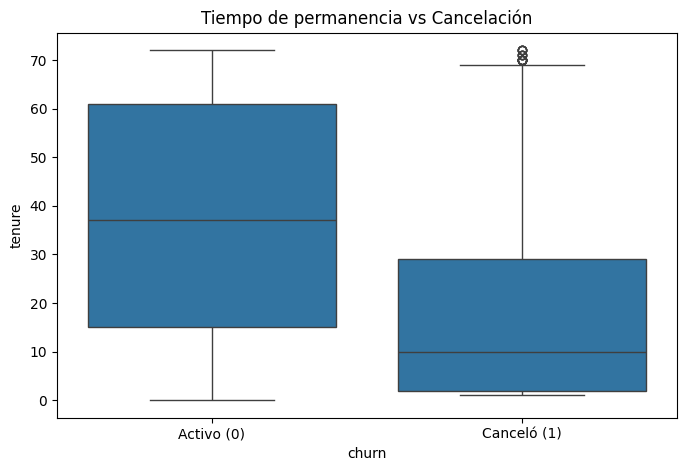

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(x='churn', y='tenure', data=df_corr)
plt.title("Tiempo de permanencia vs Cancelación")
plt.xticks([0,1], ['Activo (0)', 'Canceló (1)'])
plt.show()

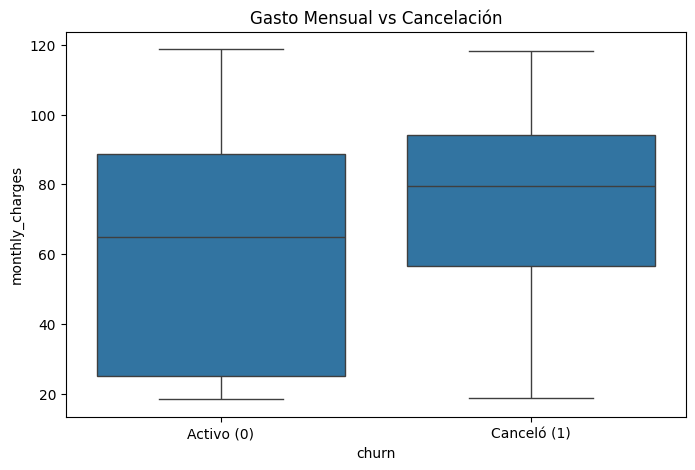

In [19]:
plt.figure(figsize=(8,5))
sns.boxplot(x='churn', y='monthly_charges', data=df_corr)
plt.title("Gasto Mensual vs Cancelación")
plt.xticks([0,1], ['Activo (0)', 'Canceló (1)'])
plt.show()

🔹 **Antigüedad del cliente**

Los clientes que cancelan el servicio suelen tener menos tiempo con la empresa. Esto indica que el riesgo de cancelación es más alto durante los primeros meses, por lo que se recomienda fortalecer estrategias de fidelización temprana.

🔹 **Costo mensual del servicio**

Se observa que los clientes con mayores cargos mensuales presentan mayor probabilidad de cancelar. Esto sugiere que el precio del servicio puede influir directamente en la decisión de baja.

🔹 **Conclusión estratégica**

El análisis evidencia que el tiempo de permanencia y el costo mensual son factores determinantes en la cancelación. En consecuencia, se recomienda implementar estrategias de retención enfocadas en clientes nuevos y en planes de mayor valor mensual.

## **modelos**

### **Baseline**

In [20]:
from sklearn.dummy import DummyClassifier

In [ ]:
dummy = DummyClassifier()
dummy.fit(X_train_final, y_train)

dummy.score(X_test_final, y_test)

0.7345635202271115

### **Regresion logistica**
*Se entrena con los datos escalados*

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

log_model = LogisticRegression(max_iter=1000)

log_model.fit(X_train_scaled, y_train)

y_pred_log = log_model.predict(X_test_scaled)

print("Matriz de Confusión - Regresión Logística")
print(confusion_matrix(y_test, y_pred_log))

print("\nReporte de Clasificación - Regresión Logística")
print(classification_report(y_test, y_pred_log))

Matriz de Confusión - Regresión Logística
[[927 108]
 [176 198]]

Reporte de Clasificación - Regresión Logística
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.53      0.58       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



La Regresión Logística muestra un buen desempeño general (80% de exactitud).

El modelo identifica correctamente la mayoría de los clientes que no cancelan (recall de 0.90), lo que indica alta capacidad para reconocer la clase mayoritaria.

Sin embargo, el desempeño en la clase de cancelación (clase 1) es considerablemente menor:

Solo detecta el 53% de los clientes que realmente cancelan.

Presenta 176 falsos negativos, lo cual es relevante desde una perspectiva de negocio, ya que estos clientes podrían perderse sin intervención preventiva.

El macro average (0.72) muestra que el rendimiento promedio entre clases es menor que el accuracy general, lo que sugiere cierto impacto del desbalance de clases (1035 vs 374).

En términos generales, la Regresión Logística ofrece un modelo equilibrado y estable, aunque con margen de mejora en la detección de clientes en riesgo.

### **Arbol de desicion**


In [22]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(random_state=42)

tree_model.fit(X_train_final, y_train)

y_pred_tree = tree_model.predict(X_test_final)

print("Matriz de Confusión - Árbol de Decisión")
print(confusion_matrix(y_test, y_pred_tree))

print("\nReporte de Clasificación - Árbol de Decisión")
print(classification_report(y_test, y_pred_tree))

Matriz de Confusión - Árbol de Decisión
[[827 208]
 [193 181]]

Reporte de Clasificación - Árbol de Decisión
              precision    recall  f1-score   support

           0       0.81      0.80      0.80      1035
           1       0.47      0.48      0.47       374

    accuracy                           0.72      1409
   macro avg       0.64      0.64      0.64      1409
weighted avg       0.72      0.72      0.72      1409



El Árbol de Decisión presenta un desempeño inferior al de la Regresión Logística (72% de accuracy).

Se observa:

Mayor cantidad de falsos positivos (208).

Mayor cantidad de falsos negativos (193).

Desempeño considerablemente bajo en la clase de cancelación (F1 = 0.47).

El modelo tiene dificultades para identificar correctamente a los clientes que cancelan, detectando menos del 50% de ellos.

Esto reduce su utilidad práctica en un escenario de retención de clientes, donde identificar correctamente a quienes están en riesgo es fundamental.

###**Conclusion sobre el rendimiento de los modelos**
Desde una perspectiva analítica y de negocio:

La Regresión Logística es el modelo más adecuado para este problema.

Aunque ambos modelos muestran mejor desempeño en la clase mayoritaria, la Regresión Logística logra un mejor equilibrio general.

Ningún modelo muestra señales graves de overfitting; sin embargo, ambos evidencian dificultades en la clase minoritaria, lo que sugiere posible desbalance en los datos.

Para mejorar la detección de cancelaciones, se recomienda:

Aplicar técnicas de balanceo de clases (SMOTE o class_weight).

Optimizar hiperparámetros.

Probar modelos ensamble como Random Forest o Gradient Boosting.

## probando valores para el parametro max_depth para el modelo **DesicionTree**



In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

# Rango de profundidades a evaluar
depths = range(1, 15)

results = []

for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train_final, y_train)

    # Predicciones
    y_train_pred = model.predict(X_train_final)
    y_test_pred = model.predict(X_test_final)

    # Métricas
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    test_f1_class1 = f1_score(y_test, y_test_pred, pos_label=1)

    results.append([depth, train_acc, test_acc, train_f1, test_f1, test_f1_class1])

# Convertir a DataFrame
results_df = pd.DataFrame(results, columns=[
    "max_depth",
    "train_accuracy",
    "test_accuracy",
    "train_f1",
    "test_f1",
    "test_f1_class1"
])

results_df


,max_depth,train_accuracy,test_accuracy,train_f1,test_f1,test_f1_class1
0,1,0.734647,0.734564,0.000000,0.000000,0.000000
1,2,0.789315,0.795600,0.505211,0.518395,0.518395
2,3,0.789315,0.795600,0.505211,0.518395,0.518395
3,4,0.791267,0.787793,0.574837,0.571019,0.571019
4,5,0.803692,0.784244,0.624830,0.592493,0.592493
5,6,0.809194,0.787083,0.563540,0.511401,0.511401
6,7,0.820199,0.774308,0.653912,0.570270,0.570270
7,8,0.837061,0.778566,0.674929,0.559322,0.559322
8,9,0.854278,0.769340,0.709381,0.531025,0.531025
9,10,0.877529,0.755855,0.761080,0.520891,0.520891


El modelo con profundidad baja (1–2) presenta underfitting, ya que el F1-score es muy bajo y no logra capturar adecuadamente la clase minoritaria.

El modelo con profundidad alta (>7) presenta overfitting, evidenciado por:

- Alta mejora en entrenamiento
- Deterioro progresivo en prueba
- Creciente brecha train-test

La profundidad óptima se encuentra en **max_depth = 5**, donde el modelo:

- Maximiza la capacidad predictiva en la clase de cancelación.
- Mantiene estabilidad en accuracy.
- Controla la diferencia entre entrenamiento y prueba.


## **Arbol de desicion parametrizado**

In [24]:
tree_model2 = DecisionTreeClassifier(random_state=42, max_depth=5)

tree_model2.fit(X_train_final, y_train)

y_pred_tree2 = tree_model2.predict(X_test_final)

print("Matriz de Confusión - Árbol de Decisión")
print(confusion_matrix(y_test, y_pred_tree2))

print("\nReporte de Clasificación - Árbol de Decisión")
print(classification_report(y_test, y_pred_tree2))

Matriz de Confusión - Árbol de Decisión
[[884 151]
 [153 221]]

Reporte de Clasificación - Árbol de Decisión
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1035
           1       0.59      0.59      0.59       374

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409

